# Path to import data

In [1]:
path_import = '/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Data/'

# Path to export data

In [2]:
path_export = '/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Dataframe_produced/Dataframe_clean/'

# Import all the data 

Import, resample them every 3H (runoff time resolution) and mask every data before the 6th of June 2021.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
# nelder-mead optimization of noisy one-dimensional convex function
from scipy.optimize import minimize
from numpy.random import rand
from scipy import interpolate
import itertools
import time
from scipy import signal
import datetime
from datetime import timedelta, date
import xarray as xr

## Ploughmeter data

In [4]:
df_plough=pd.read_table(path_import+'ploughmeter/df_LTheta.csv', sep=',', index_col = [0], header=[0], parse_dates=[0])

In [5]:
mask=(df_plough.index >= '2021-05-16 23:50:00')
df_plough=df_plough.loc[mask]

In [6]:
df_plough

,X,Y,V1V,V1,Lx,Ly,L,Theta,Pe
TIMESTAMP,,,,,,,,,
2021-05-16 23:50:00,1.362810,0.033041,3.137733,2.275466,-6.625777,6.452701,9.248690,135.758187,2.740651
2021-05-17 00:00:00,1.362881,0.033108,3.137738,2.275476,-6.608909,6.468959,9.247979,135.613114,2.740641
2021-05-17 00:10:00,1.362997,0.033191,3.137743,2.275486,-6.580926,6.489320,9.242287,135.401565,2.740676
2021-05-17 00:20:00,1.362942,0.033138,3.137750,2.275499,-6.594297,6.476245,9.242646,135.517479,2.740664
2021-05-17 00:30:00,1.362987,0.033089,3.137763,2.275526,-6.583512,6.464441,9.226680,135.522842,2.740705
...,...,...,...,...,...,...,...,...,...
2022-08-18 16:50:00,1.178450,0.052659,3.132645,2.265289,-50.841983,11.234151,52.068353,167.540013,2.960870
2022-08-18 17:00:00,1.178451,0.052652,3.132649,2.265298,-50.841763,11.232505,52.067784,167.541729,2.961262
2022-08-18 17:10:00,1.178443,0.052662,3.132716,2.265433,-50.843747,11.235091,52.070278,167.539422,2.961649


In [7]:
df_plough_3H = df_plough.rolling(18, center = True).mean()

In [8]:
df_plough_3H.reset_index(inplace=True)

In [9]:
df_plough_3H = df_plough_3H[(df_plough_3H.index % 18) == 1]

In [10]:
df_plough_3H

,TIMESTAMP,X,Y,V1V,V1,Lx,Ly,L,Theta,Pe
1,2021-05-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,2021-05-17 03:00:00,1.362387,0.034156,3.137807,2.275613,-6.727232,6.724370,9.512179,135.021135,2.740705
37,2021-05-17 06:00:00,1.360434,0.036197,3.137568,2.275137,-7.195831,7.221857,10.194954,134.893195,2.740674
55,2021-05-17 09:00:00,1.359011,0.037613,3.137297,2.274593,-7.536913,7.566968,10.680319,134.890206,2.740733
73,2021-05-17 12:00:00,1.357409,0.039236,3.137039,2.274079,-7.921180,7.962526,11.231762,134.847066,2.741255
...,...,...,...,...,...,...,...,...,...,...
65971,2022-08-18 03:00:00,1.178503,0.052629,3.131980,2.263960,-50.829246,11.226981,52.054369,167.544694,2.940760
65989,2022-08-18 06:00:00,1.178375,0.052659,3.132338,2.264676,-50.859890,11.234288,52.085868,167.544116,2.941868
66007,2022-08-18 09:00:00,1.178287,0.052677,3.132079,2.264159,-50.881090,11.238622,52.107504,167.544491,2.943030
66025,2022-08-18 12:00:00,1.178284,0.052653,3.132352,2.264705,-50.881727,11.232875,52.106887,167.550812,2.947946


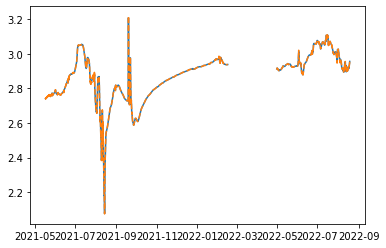

In [11]:
plt.plot(df_plough_3H['TIMESTAMP'], df_plough_3H['Pe'])
plt.plot(df_plough.index, df_plough['Pe'], '--')

In [12]:
df_plough_3H_LPe = df_plough_3H[['TIMESTAMP', 'L',  'Pe']]

In [13]:
mask=(df_plough_3H_LPe['TIMESTAMP'] >= '2021-06-15 00:00:00')
df_plough_3H_LPe = df_plough_3H_LPe.loc[mask]

In [14]:
df_plough_3H_LPe['L']=df_plough_3H_LPe['L']*9.8

In [15]:
df_plough_3H_LPe.reset_index(inplace=True, drop=True)

In [16]:
df_plough_3H_LPe

,TIMESTAMP,L,Pe
0,2021-06-15 00:00:00,74.485646,2.798299
1,2021-06-15 03:00:00,74.640594,2.798578
2,2021-06-15 06:00:00,74.651018,2.798510
3,2021-06-15 09:00:00,74.841066,2.799789
4,2021-06-15 12:00:00,75.202417,2.802315
...,...,...,...
3433,2022-08-18 03:00:00,510.132819,2.940760
3434,2022-08-18 06:00:00,510.441503,2.941868
3435,2022-08-18 09:00:00,510.653536,2.943030
3436,2022-08-18 12:00:00,510.647491,2.947946


In [17]:
df_plough_3H_LPe.loc[df_plough_3H_LPe.index > 3421, 'L'] = np.nan

In [18]:
df_plough_3H_LPe

,TIMESTAMP,L,Pe
0,2021-06-15 00:00:00,74.485646,2.798299
1,2021-06-15 03:00:00,74.640594,2.798578
2,2021-06-15 06:00:00,74.651018,2.798510
3,2021-06-15 09:00:00,74.841066,2.799789
4,2021-06-15 12:00:00,75.202417,2.802315
...,...,...,...
3433,2022-08-18 03:00:00,NaN,2.940760
3434,2022-08-18 06:00:00,NaN,2.941868
3435,2022-08-18 09:00:00,NaN,2.943030
3436,2022-08-18 12:00:00,NaN,2.947946


In [19]:
df_plough_3H_LPe.to_csv(path_export+'raw_data_3H/df_plough_LPe_3H.csv')

# Sismo data

## Sismo data KGS01

## Data 2021

In [20]:
data01_f = pd.read_csv(path_import+'seismo/KGS01/2021_KGS01_EHZ_frequency', header = None)
data01_psd = np.loadtxt(path_import+'seismo/KGS01/2021_KGS01_EHZ_PSD_resampled_ncorr')
data01_time = pd.read_csv(path_import+'seismo/KGS01/2021_KGS01_EHZ_time_resampled', header = None)

Convert time in s from seismic data

In [21]:
data01_time[0] = pd.to_datetime(data01_time[0], unit='s')

In [22]:
data01_time.columns = ['TIMESTAMP']

In [23]:
data01_psd

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 1.08335863,  0.85375165,  0.68548201, ..., -2.5783015 ,
        -2.5764511 , -2.92477177],
       [ 1.24352947,  0.99870773,  0.8961565 , ..., -2.36184188,
        -2.37659866, -2.75085903],
       ...,
       [ 1.16080755,  0.9114143 ,  0.74313863, ..., -2.60398751,
        -2.60624098, -2.94523772],
       [ 1.1748312 ,  0.91475176,  0.75276393, ..., -2.59636203,
        -2.66780823, -3.02017101],
       [ 1.17049333,  0.91984072,  0.73720008, ..., -2.61600889,
        -2.67125664, -3.01578253]])

Take frequencies between 3 and 10 Hz and 30-45 Hz

In [24]:
data01_psd_3_10 = data01_psd[:, 3:8]
data01_psd_30_45 = data01_psd[:, 28:43]

Take the median between the range of frequencies

In [25]:
df_psd01_3_10 = pd.DataFrame(np.median(data01_psd_3_10, axis=1), columns=['PSD'])
df_psd01_30_45 = pd.DataFrame(np.median(data01_psd_30_45, axis=1), columns=['PSD'])

In [26]:
df_psd01_3_10 = pd.concat([data01_time, df_psd01_3_10], axis=1)
df_psd01_30_45 = pd.concat([data01_time, df_psd01_30_45], axis=1)

In [27]:
df_psd01_30_45

,TIMESTAMP,PSD
0,2021-01-01 00:00:01,NaN
1,2021-01-01 00:02:31,-0.022557
2,2021-01-01 00:05:01,0.123276
3,2021-01-01 00:07:31,0.143482
4,2021-01-01 00:10:01,-0.025501
...,...,...
205627,2021-12-31 23:47:31,-0.053236
205628,2021-12-31 23:50:01,-0.076833
205629,2021-12-31 23:52:31,-0.093271
205630,2021-12-31 23:55:01,-0.082650


In [28]:
df_psd01_3_10.set_index('TIMESTAMP', inplace=True)
df_psd01_30_45.set_index('TIMESTAMP', inplace=True)

In [29]:
df_psd01_3_10_10min = df_psd01_3_10.resample('10Min').mean()
df_psd01_30_45_10min = df_psd01_30_45.resample('10Min').mean()

In [30]:
mask=(df_psd01_3_10_10min.index >= '2021-05-16 23:50:00')
df_psd01_3_10_10min=df_psd01_3_10_10min.loc[mask]

mask=(df_psd01_30_45_10min.index >= '2021-05-16 23:50:00')
df_psd01_30_45_10min=df_psd01_30_45_10min.loc[mask]


In [31]:
df_psd01_30_45_10min

,PSD
TIMESTAMP,
2021-05-16 23:50:00,-0.017555
2021-05-17 00:00:00,-0.022095
2021-05-17 00:10:00,-0.034380
2021-05-17 00:20:00,0.015983
2021-05-17 00:30:00,-0.046739
...,...
2021-12-31 23:10:00,-0.021499
2021-12-31 23:20:00,-0.065253
2021-12-31 23:30:00,-0.074165


In [32]:
df_psd01_3_10_3H = df_psd01_3_10_10min.rolling(18).mean()
df_psd01_30_45_3H = df_psd01_30_45_10min.rolling(18).mean()

In [33]:
df_psd01_3_10_3H

,PSD
TIMESTAMP,
2021-05-16 23:50:00,NaN
2021-05-17 00:00:00,NaN
2021-05-17 00:10:00,NaN
2021-05-17 00:20:00,NaN
2021-05-17 00:30:00,NaN
...,...
2021-12-31 23:10:00,0.451264
2021-12-31 23:20:00,0.451795
2021-12-31 23:30:00,0.453648


In [34]:
df_psd01_3_10_3H.reset_index(inplace=True)
df_psd01_30_45_3H.reset_index(inplace=True)

In [35]:
df_psd01_3_10_3H.iloc[-6][0]

Timestamp('2021-12-31 23:00:00')

In [36]:
end3_10 = pd.DataFrame({'TIMESTAMP':[df_psd01_3_10_3H.iloc[-6][0]], 'P3-10':[df_psd01_3_10_3H.iloc[-6][1]]})
end30_45 = pd.DataFrame({'TIMESTAMP':[df_psd01_30_45_3H.iloc[-6][0]], 'P30-45':[df_psd01_30_45_3H.iloc[-6][1]]})

In [37]:
df_psd01_3_10_3H = df_psd01_3_10_3H[(df_psd01_3_10_3H.index % 18) == 1]
df_psd01_30_45_3H = df_psd01_30_45_3H[(df_psd01_30_45_3H.index % 18) == 1]

In [38]:
df_psd01_3_10_3H

,TIMESTAMP,PSD
1,2021-05-17 00:00:00,NaN
19,2021-05-17 03:00:00,0.454187
37,2021-05-17 06:00:00,0.431756
55,2021-05-17 09:00:00,0.444889
73,2021-05-17 12:00:00,0.485750
...,...,...
32887,2021-12-31 09:00:00,0.453565
32905,2021-12-31 12:00:00,0.433500
32923,2021-12-31 15:00:00,0.436997
32941,2021-12-31 18:00:00,0.473278


In [39]:
df_psd01_3_10_3H.shape

(1832, 2)

In [40]:
mask=(df_psd01_3_10_3H['TIMESTAMP'] >= '2021-06-15 00:00:00')
df_psd01_3_10_3H=df_psd01_3_10_3H.loc[mask]

mask=(df_psd01_30_45_3H['TIMESTAMP'] >= '2021-06-15 00:00:00')
df_psd01_30_45_3H=df_psd01_30_45_3H.loc[mask]

In [41]:
df_psd01_3_10_3H.columns=['TIMESTAMP', 'P3-10']
df_psd01_30_45_3H.columns=['TIMESTAMP', 'P30-45']

In [42]:
df_psd01_3_10_3H = pd.concat([df_psd01_3_10_3H, end3_10])
df_psd01_30_45_3H = pd.concat([df_psd01_30_45_3H, end30_45])

In [43]:
df_psd01_3_10_3H.reset_index(inplace=True)
df_psd01_30_45_3H.reset_index(inplace=True)

In [44]:
df_psd01_3_10_3H.drop(columns=['index'], inplace=True)
df_psd01_30_45_3H.drop(columns=['index'], inplace=True)

In [45]:
df_psd01_3_10_3H

,TIMESTAMP,P3-10
0,2021-06-15 00:00:00,0.498721
1,2021-06-15 03:00:00,0.510933
2,2021-06-15 06:00:00,0.496313
3,2021-06-15 09:00:00,0.496620
4,2021-06-15 12:00:00,0.499770
...,...,...
1596,2021-12-31 12:00:00,0.433500
1597,2021-12-31 15:00:00,0.436997
1598,2021-12-31 18:00:00,0.473278
1599,2021-12-31 21:00:00,0.439955


## Data 2022 

In [46]:
data0122_psd = np.loadtxt(path_import+'seismo/KGS01/2022_KGS01_EHZ_PSD_resampled_nc')
data0122_time = pd.read_csv(path_import+'seismo/KGS01/2022_KGS01_EHZ_time_resampled', header = None)

In [47]:
data0122_time[0] = pd.to_datetime(data0122_time[0], unit='s')

In [48]:
data0122_time.columns=['TIMESTAMP']

In [49]:
data0122_psd_3_10 = data0122_psd[:, 3:8]
data0122_psd_30_45 = data0122_psd[:, 28:43]

In [50]:
df_psd0122_3_10 = pd.DataFrame(np.median(data0122_psd_3_10, axis=1), columns=['PSD'])
df_psd0122_30_45 = pd.DataFrame(np.median(data0122_psd_30_45, axis=1), columns=['PSD'])

In [51]:
df_psd0122_3_10 = pd.concat([data0122_time, df_psd0122_3_10], axis=1)
df_psd0122_30_45 = pd.concat([data0122_time, df_psd0122_30_45], axis=1)

In [52]:
df_psd0122_3_10.set_index('TIMESTAMP', inplace=True)
df_psd0122_30_45.set_index('TIMESTAMP', inplace=True)

In [53]:
df_psd0122_3_10_10min = df_psd0122_3_10.resample('10Min').mean()
df_psd0122_30_45_10min = df_psd0122_30_45.resample('10Min').mean()

In [54]:
mask=(df_psd0122_3_10_10min.index >= '2022-01-01 05:50:00')
df_psd0122_3_10_10min=df_psd0122_3_10_10min.loc[mask]

In [55]:
df_psd0122_3_10_10min

,PSD
TIMESTAMP,
2022-01-01 05:50:00,0.399542
2022-01-01 06:00:00,0.458080
2022-01-01 06:10:00,0.486468
2022-01-01 06:20:00,0.410823
2022-01-01 06:30:00,0.549540
...,...
2022-08-22 23:20:00,0.449470
2022-08-22 23:30:00,0.427590
2022-08-22 23:40:00,0.425328


In [56]:
mask=(df_psd0122_30_45_10min.index >= '2022-01-01 05:50:00')
df_psd0122_30_45_10min=df_psd0122_30_45_10min.loc[mask]

In [57]:
df_psd0122_30_45_10min

,PSD
TIMESTAMP,
2022-01-01 05:50:00,-0.039497
2022-01-01 06:00:00,-0.055802
2022-01-01 06:10:00,-0.050491
2022-01-01 06:20:00,-0.058184
2022-01-01 06:30:00,-0.046778
...,...
2022-08-22 23:20:00,0.023608
2022-08-22 23:30:00,0.019392
2022-08-22 23:40:00,0.035987


In [58]:
df_psd0122_3_10_3H = df_psd0122_3_10_10min.rolling(18).mean()
df_psd0122_30_45_3H = df_psd0122_30_45_10min.rolling(18).mean()

In [59]:
df_psd0122_30_45_3H

,PSD
TIMESTAMP,
2022-01-01 05:50:00,NaN
2022-01-01 06:00:00,NaN
2022-01-01 06:10:00,NaN
2022-01-01 06:20:00,NaN
2022-01-01 06:30:00,NaN
...,...
2022-08-22 23:20:00,0.012250
2022-08-22 23:30:00,0.012297
2022-08-22 23:40:00,0.014539


In [60]:
df_psd0122_3_10_3H.reset_index(inplace=True)
df_psd0122_30_45_3H.reset_index(inplace=True)

In [61]:
df_psd0122_3_10_3H = df_psd0122_3_10_3H[(df_psd0122_3_10_3H.index % 18) == 1]
df_psd0122_30_45_3H = df_psd0122_30_45_3H[(df_psd0122_30_45_3H.index % 18) == 1]

In [62]:
df_psd0122_30_45_3H

,TIMESTAMP,PSD
1,2022-01-01 06:00:00,NaN
19,2022-01-01 09:00:00,-0.053430
37,2022-01-01 12:00:00,-0.043667
55,2022-01-01 15:00:00,-0.056788
73,2022-01-01 18:00:00,-0.053667
...,...,...
33589,2022-08-22 12:00:00,0.013323
33607,2022-08-22 15:00:00,0.013120
33625,2022-08-22 18:00:00,0.010710
33643,2022-08-22 21:00:00,0.010561


In [63]:
df_psd0122_3_10_3H.columns=['TIMESTAMP', 'P3-10']
df_psd0122_30_45_3H.columns=['TIMESTAMP', 'P30-45']

In [64]:
df_psd01_3_10_3H_2122 = pd.concat([df_psd01_3_10_3H, df_psd0122_3_10_3H])
df_psd01_30_45_3H_2122 = pd.concat([df_psd01_30_45_3H, df_psd0122_30_45_3H])

<AxesSubplot:>

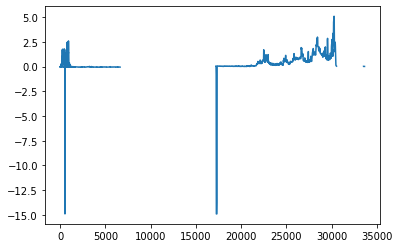

In [65]:
df_psd01_30_45_3H_2122['P30-45'].plot()

In [66]:
df_psd01_3_10_3H_2122.set_index('TIMESTAMP', inplace=True)
df_psd01_30_45_3H_2122.set_index('TIMESTAMP', inplace=True)

In [67]:
df_psd01_3H_2122 = pd.concat([df_psd01_3_10_3H_2122, df_psd01_30_45_3H_2122], axis=1)

## R and S from seismology

In [68]:
df_RS = pd.read_csv(path_import+'seismo/RSQP_2020_2022_3hr_stake6_reltoJun24_2021.csv',
                   sep=',', header=[0], parse_dates=[4])
df_RS

,Qrel stake 6,Prel stake 6,Rrel stake 6,Srel stake 6,Time
0,0.5,0.973482,0.703226,1.634682,2021-06-23 00:02:30
1,0.5,0.973118,0.703255,1.634324,2021-06-23 00:05:00
2,0.5,0.972753,0.703284,1.633966,2021-06-23 00:07:30
3,0.5,0.972389,0.703313,1.633608,2021-06-23 00:10:00
4,0.5,0.972169,0.703330,1.633391,2021-06-23 00:12:30
...,...,...,...,...,...
285690,NaN,NaN,NaN,NaN,2022-10-31 23:47:30
285691,NaN,NaN,NaN,NaN,2022-10-31 23:50:00
285692,NaN,NaN,NaN,NaN,2022-10-31 23:52:30
285693,NaN,NaN,NaN,NaN,2022-10-31 23:55:00


In [69]:
df_RS_small = df_RS[['Rrel stake 6', 'Srel stake 6', 'Time']]

In [70]:
df_RS_small.set_index('Time', inplace=True)

In [71]:
df_RS_10min=df_RS_small.resample('10Min').mean()

In [72]:
mask= (df_RS_10min.index>='2021-06-23 02:50:00')
df_RS_10min=df_RS_10min.loc[mask]

<AxesSubplot:xlabel='Time'>

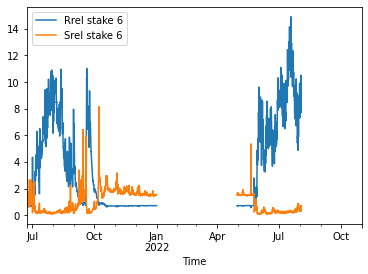

In [73]:
df_RS_10min.plot()

In [74]:
df_RS_3H = df_RS_10min.rolling(18).mean()

In [75]:
df_RS_3H.reset_index(inplace=True)

In [76]:
df_RS_3H = df_RS_3H[(df_RS_3H.index % 18) == 1]
df_RS_3H

,Time,Rrel stake 6,Srel stake 6
1,2021-06-23 03:00:00,NaN,NaN
19,2021-06-23 06:00:00,0.844712,1.250807
37,2021-06-23 09:00:00,0.803241,1.356680
55,2021-06-23 12:00:00,0.701146,1.661752
73,2021-06-23 15:00:00,0.699529,1.681291
...,...,...,...
71317,2022-10-31 09:00:00,NaN,NaN
71335,2022-10-31 12:00:00,NaN,NaN
71353,2022-10-31 15:00:00,NaN,NaN
71371,2022-10-31 18:00:00,NaN,NaN


<AxesSubplot:>

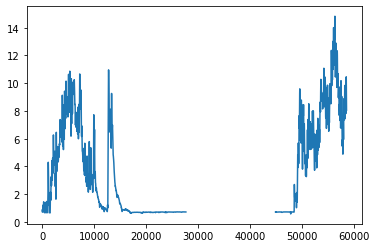

In [77]:
df_RS_3H['Rrel stake 6'].plot()

In [78]:
df_RS_3H['Time'] = pd.to_datetime(df_RS_3H['Time'])

In [79]:
df_RS_3H.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3967 entries, 1 to 71389
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          3967 non-null   datetime64[ns]
 1   Rrel stake 6  2289 non-null   float64       
 2   Srel stake 6  2289 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 124.0 KB


In [80]:
# mask = (df_RS_3H['Time']<'2022-01-01 03:00:00')
# df_RS_3H=df_RS_3H.loc[mask]

In [81]:
df_RS_3H.columns=['TIMESTAMP', 'R', 'S']

In [82]:
df_RS_3H.set_index('TIMESTAMP', inplace=True)

<AxesSubplot:xlabel='TIMESTAMP'>

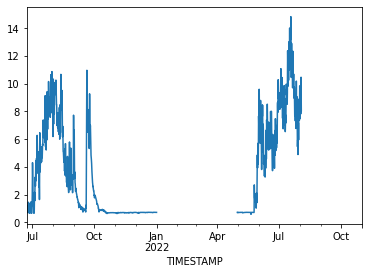

In [83]:
df_RS_3H.R.plot()

In [84]:
df_seismo = pd.concat([df_psd01_3H_2122, df_RS_3H], axis=1)

<AxesSubplot:xlabel='TIMESTAMP'>

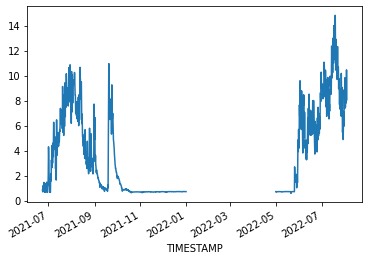

In [85]:
df_seismo.R.plot()

In [86]:
mask = (df_seismo.index<='2022-08-18 17:30:00')
df_seismo = df_seismo.loc[mask]

<AxesSubplot:xlabel='TIMESTAMP'>

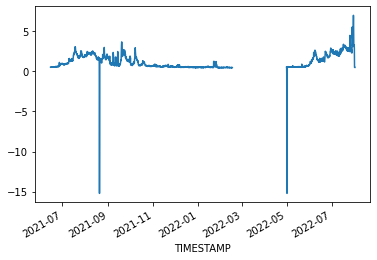

In [87]:
df_seismo['P3-10'].plot()

In [88]:
for i in df_seismo.loc[df_seismo['P3-10']<-2].index:
    df_seismo['P3-10'][i]=np.nan
for i in df_seismo.loc[df_seismo['P30-45']<-2].index:
    df_seismo['P30-45'][i]=np.nan

<AxesSubplot:xlabel='TIMESTAMP'>

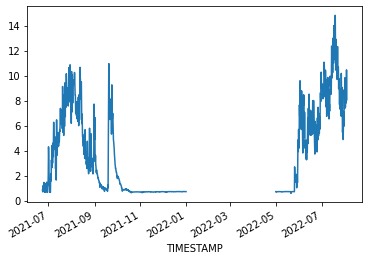

In [89]:
df_seismo['R'].plot()

In [90]:
df_seismo['P3-10']=(df_seismo['P3-10']*10)-186.1120
df_seismo['P30-45']=(df_seismo['P30-45']*10)-186.1120

<AxesSubplot:xlabel='TIMESTAMP'>

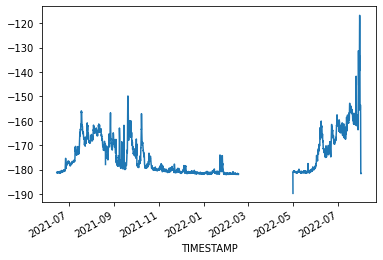

In [91]:
df_seismo['P3-10'].plot()

In [92]:
df_seismo.to_csv(path_export+'raw_data_3H/df_seismo2122_3H.csv')

# Runoff data

In [93]:
data_runoff2122 = pd.read_csv(path_import+'Runoff/runoff_2020_2021_2022_3hr.csv',
                             header=[0])

In [94]:
data_runoff2122['Time UTC']=pd.to_datetime(data_runoff2122['Time UTC'])

In [95]:
data_runoff2122.columns

Index(['Q stake 3 (m3/sec)', 'Q stake 6 (m3/sec)', 'Time UTC'], dtype='object')

In [96]:
data_runoff2122=data_runoff2122[['Q stake 6 (m3/sec)', 'Time UTC']]

In [97]:
data_runoff2122.columns=['Runoff', 'TIMESTAMP']

In [98]:
data_runoff2122

,Runoff,TIMESTAMP
0,0.000000,2020-01-01 12:00:00
1,0.000000,2020-01-01 15:00:00
2,0.000000,2020-01-01 18:00:00
3,0.000000,2020-01-01 21:00:00
4,0.000000,2020-01-02 00:00:00
...,...,...
7907,0.121071,2022-09-15 21:00:00
7908,0.117632,2022-09-16 00:00:00
7909,0.116929,2022-09-16 03:00:00
7910,0.133005,2022-09-16 06:00:00


In [99]:
data_runoff2122.set_index('TIMESTAMP', inplace=True)

In [100]:
mask = ((data_runoff2122.index>='2021-06-15 00:00:00') & (data_runoff2122.index<='2022-08-18 05:00:00'))
data_runoff2122_3H = data_runoff2122.loc[mask]

In [101]:
data_runoff2122_3H

,Runoff
TIMESTAMP,
2021-06-15 00:00:00,0.000000
2021-06-15 03:00:00,0.000000
2021-06-15 06:00:00,0.000000
2021-06-15 09:00:00,0.000000
2021-06-15 12:00:00,0.000000
...,...
2022-08-17 15:00:00,1.743442
2022-08-17 18:00:00,3.649433
2022-08-17 21:00:00,5.262780


In [102]:
data_runoff2122_3H.to_csv(path_export+'raw_data_3H/df_runoff_3H.csv')

# Velocity data

In [103]:
data_velocity = pd.read_csv(path_import+'velocity/vitesse_ceslav_mpday.csv', header=None)
data_time=pd.read_csv(path_import+'velocity/time_vitesse_ceslav_mpday.csv', header=None)

In [104]:
data_velocity_pim = pd.read_csv(path_import+'velocity/vel_KNG-6_2021.csv', header=[0], parse_dates=[0])

In [105]:
data_velocity_kng5=pd.read_csv(path_import+'velocity/vel_sg_nya1_kng5_static_2021-2023.csv', header=[0], parse_dates=[0])
data_velocity_kng6=pd.read_csv(path_import+'velocity/vel_sg_nya1_kng6_static_2021-2023.csv', header=[0], parse_dates=[0])
data_velocity_kng7=pd.read_csv(path_import+'velocity/vel_sg_nya1_kng7_static_2021-2023.csv', header=[0], parse_dates=[0])

In [106]:
data_velocity_kng5.columns

Index(['Index', 'velocity_sg.zoo_med_3hr', 'velocity_sg.zoo_med_24hr',
       'velocity_sg.zoo_days'],
      dtype='object')

In [107]:
data_velocity_kng5=data_velocity_kng5[['Index', 'velocity_sg.zoo_med_24hr']]
data_velocity_kng6=data_velocity_kng6[['Index', 'velocity_sg.zoo_med_24hr']]
data_velocity_kng7=data_velocity_kng7[['Index', 'velocity_sg.zoo_med_24hr']]

In [108]:
data_velocity_kng5.columns=['TIMESTAMP', 'Velocity']
data_velocity_kng6.columns=['TIMESTAMP', 'Velocity']
data_velocity_kng7.columns=['TIMESTAMP', 'Velocity']

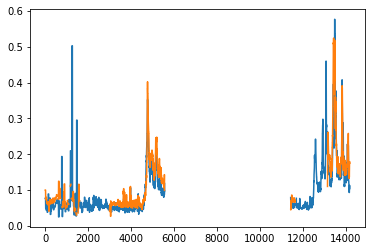

In [109]:
fig, ax = plt.subplots()
ax.plot(data_velocity_kng5['Velocity'])
ax.plot(data_velocity_kng6['Velocity'])

In [110]:
mask = (data_velocity_kng5['TIMESTAMP']>='2021-06-15 00:00:00') & (data_velocity_kng5['TIMESTAMP']<='2022-08-18 15:00:00')
data_velocity_kng5 = data_velocity_kng5.loc[mask]

mask = (data_velocity_kng6['TIMESTAMP']>='2021-06-15 00:00:00') & (data_velocity_kng6['TIMESTAMP']<='2022-08-18 15:00:00')
data_velocity_kng6 = data_velocity_kng6.loc[mask]

mask = (data_velocity_kng7['TIMESTAMP']>='2021-06-15 00:00:00') & (data_velocity_kng7['TIMESTAMP']<='2022-08-18 15:00:00')
data_velocity_kng7 = data_velocity_kng7.loc[mask]

In [111]:
data_velocity_kng5.set_index('TIMESTAMP', inplace=True)
data_velocity_kng6.set_index('TIMESTAMP', inplace=True)
data_velocity_kng7.set_index('TIMESTAMP', inplace=True)

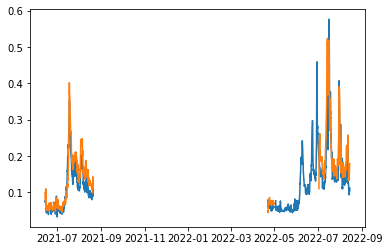

In [112]:
fig, ax = plt.subplots()
ax.plot(data_velocity_kng5['Velocity'])
ax.plot(data_velocity_kng6['Velocity'])

In [113]:
data_velocity_kng5 = data_velocity_kng5.rolling(3, min_periods=1, center=True).mean()

In [114]:
data_velocity_kng6 = data_velocity_kng6.rolling(3, min_periods=1, center=True).mean()

In [115]:
data_velocity_kng7= data_velocity_kng7.rolling(3, min_periods=1, center=True).mean()

In [116]:
data_velocity_kng5= data_velocity_kng5.iloc[::3, :]
data_velocity_kng6= data_velocity_kng6.iloc[::3, :]
data_velocity_kng7= data_velocity_kng7.iloc[::3, :]

<AxesSubplot:xlabel='TIMESTAMP'>

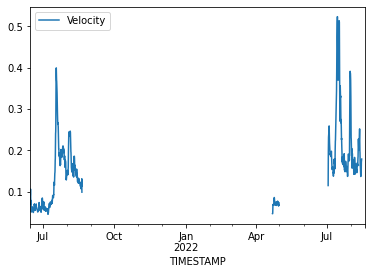

In [117]:
data_velocity_kng6.plot()

In [118]:
data_velocity_pim = data_velocity_pim[['day', 'velocity.mean']]

In [119]:
data_velocity_pim.columns=['TIMESTAMP', 'Velocity']

In [120]:
mask = (data_velocity_pim['TIMESTAMP']>='2021-06-14 23:50:00') & (data_velocity_pim['TIMESTAMP']<='2022-02-15 20:50:00')
df_velocity_pim = data_velocity_pim.loc[mask]

In [121]:
df_velocity_pim.set_index('TIMESTAMP', inplace=True)

In [122]:
df_velocity_pim = df_velocity_pim.resample('3H').mean()
df_velocity_pim=df_velocity_pim.interpolate(method='linear')

In [123]:
df_velocity_pim

,Velocity
TIMESTAMP,
2021-06-15 00:00:00,8.694892
2021-06-15 03:00:00,10.106296
2021-06-15 06:00:00,11.517700
2021-06-15 09:00:00,12.929104
2021-06-15 12:00:00,14.340509
...,...
2021-08-18 12:00:00,42.310583
2021-08-18 15:00:00,42.171657
2021-08-18 18:00:00,42.032732


In [124]:
data_velocity.columns=['Velocity']
data_time.columns=['TIMESTAMP']

In [125]:
df_velocity=pd.concat([data_time, data_velocity], axis=1)

In [126]:
df_velocity['TIMESTAMP']=pd.to_datetime(df_velocity['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

In [127]:
df_velocity

,TIMESTAMP,Velocity
0,2021-09-06,NaN
1,2021-09-07,0.098481
2,2021-09-08,0.055077
3,2021-09-09,0.064008
4,2021-09-10,0.045109
...,...,...
116,2021-12-31,0.110904
117,2022-01-01,0.110903
118,2022-01-02,0.097301
119,2022-01-03,0.088653


In [128]:
mask = (df_velocity['TIMESTAMP']>='2021-06-14 23:50:00') & (df_velocity['TIMESTAMP']<='2022-02-15 20:50:00')
df_velocity_2122 = df_velocity.loc[mask]

In [129]:
df_velocity_2122.set_index('TIMESTAMP', inplace=True)

In [130]:
df_velocity_int = df_velocity_2122.resample('3H').mean()
df_velocity_int=df_velocity_int.interpolate(method='linear')

In [131]:
df_velocity_int

,Velocity
TIMESTAMP,
2021-09-06 00:00:00,NaN
2021-09-06 03:00:00,NaN
2021-09-06 06:00:00,NaN
2021-09-06 09:00:00,NaN
2021-09-06 12:00:00,NaN
...,...
2022-01-03 12:00:00,0.088653
2022-01-03 15:00:00,0.088653
2022-01-03 18:00:00,0.088653


In [132]:
df_velocity_int['Velocity']=df_velocity_int['Velocity']*365.25

In [133]:
df_velocity_pim_ceslav = pd.concat([df_velocity_pim, df_velocity_int])

In [134]:
df_velocity_pim_ceslav

,Velocity
TIMESTAMP,
2021-06-15 00:00:00,8.694892
2021-06-15 03:00:00,10.106296
2021-06-15 06:00:00,11.517700
2021-06-15 09:00:00,12.929104
2021-06-15 12:00:00,14.340509
...,...
2022-01-03 12:00:00,32.380376
2022-01-03 15:00:00,32.380376
2022-01-03 18:00:00,32.380376


In [135]:
data_velocity_kng5['KNG5']=data_velocity_kng5['Velocity']*365.25

In [136]:
data_velocity_kng6['KNG6']=data_velocity_kng6['Velocity']*365.25

In [137]:
data_velocity_kng7['KNG7']=data_velocity_kng7['Velocity']*365.25

In [138]:
df_all_velocity1=pd.concat([df_velocity_pim_ceslav, data_velocity_kng6['KNG6']], axis=1)

In [139]:
df_all_velocity2=pd.concat([df_all_velocity1, data_velocity_kng7['KNG7']], axis=1)

In [140]:
df_all_velocity=pd.concat([df_all_velocity2, data_velocity_kng5['KNG5']], axis=1)

In [141]:
df_all_velocity.describe()

,Velocity,KNG6,KNG7,KNG5
count,1474.000000,946.000000,1772.000000,1429.000000
mean,47.740276,57.145151,44.078756,45.362355
std,21.832508,33.511432,32.668938,29.290917
min,8.694892,16.618875,8.400750,11.870625
25%,35.172725,26.374094,28.672125,20.819250
50%,46.131565,55.913687,35.977125,40.968875
75%,56.599342,69.443156,48.684781,56.735500
max,135.557043,191.025750,413.463000,206.670625


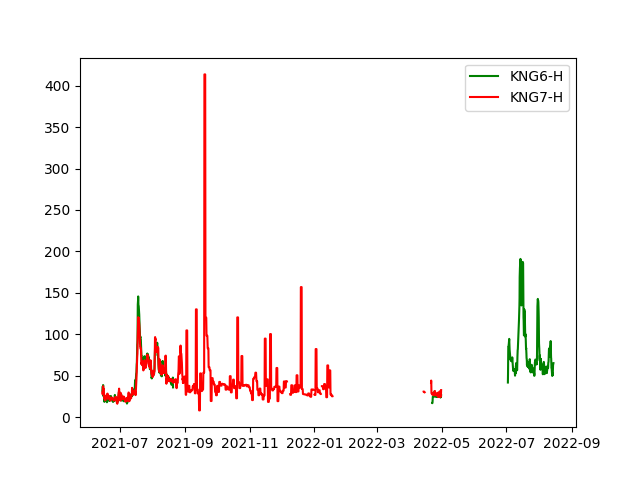

In [142]:
%matplotlib widget

plt.plot(df_all_velocity['KNG6'], 'g', label='KNG6-H')
plt.plot(df_all_velocity['KNG7'], 'r', label='KNG7-H')
# plt.plot(df_all_velocity['Velocity'], 'k', label='KNG6+Ceslav Day')
plt.legend()
plt.savefig(path_import+'velocity/velocity_rolling_mean.pdf', bbox_inches='tight')

In [143]:
df_all_velocity

,Velocity,KNG6,KNG7,KNG5
TIMESTAMP,,,,
2021-06-15 00:00:00,8.694892,36.342375,30.133125,27.850313
2021-06-15 03:00:00,10.106296,31.046250,27.759000,26.663250
2021-06-15 06:00:00,11.517700,32.933375,30.620125,27.089375
2021-06-15 09:00:00,12.929104,34.333500,33.663875,27.150250
2021-06-15 12:00:00,14.340509,38.899125,37.559875,28.306875
...,...,...,...,...
2022-08-18 03:00:00,NaN,NaN,NaN,NaN
2022-08-18 06:00:00,NaN,NaN,NaN,NaN
2022-08-18 09:00:00,NaN,NaN,NaN,NaN


In [144]:
df_all_velocity.to_csv(path_export+'raw_data_3H/df_velocity_3H.csv')

# Meteo data

In [145]:
data_st=xr.open_dataset(path_import+'snow_thickness/aws-sw-215-20210429-20220501.nc')

In [146]:
import scipy.io
data_carra = scipy.io.loadmat(path_import+'meteo/CARRA_Tair_precip_13.1_78.7_2021.mat')

In [147]:
import mat73
data_arome = mat73.loadmat(path_import+'meteo/cryogridOutput_kng6.mat')

In [219]:
data_arome

{'T': array([[-3.86529849e-01, -3.86392380e-01, -3.86255431e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.85166422e-01, -3.85034761e-01, -3.84902307e-01, ...,
         -1.01694195e-06, -1.01444417e-06, -1.01195248e-06],
        [-3.82504484e-01, -3.82369715e-01, -3.82234958e-01, ...,
         -2.02608551e-06, -2.02111548e-06, -2.01615754e-06],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]),
 'T2': array([-15.58676243, -19.41629028, -16.28554153, ...,          nan,
                 nan,          nan]),
 'cmb': array([ 0.00043545,  0.00063544,  0.00097196, ..., -0.06910051,
        -0.06715061, -0.06494692]),
 'd

In [149]:
date=[]
for i in range(len(data_arome['date'])):
    date.append(int(data_arome['date'][[i]]))

In [150]:
len(date)

11688

In [151]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return pd.Timestamp.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [152]:
date_time=[]
for i in range(len(date)):
    date_time.append(datenum_to_datetime(date[i]))

(-0.1, 0.1)

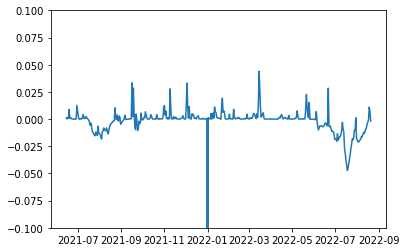

In [280]:
plt.plot(date_time[11122:11554], np.diff(data_arome['cmb'][11122:11555]))
plt.ylim([-0.1, 0.1])

In [154]:
data_arome['T2']

array([-15.58676243, -19.41629028, -16.28554153, ...,          nan,
                nan,          nan])

In [217]:
df_arome_meteo22=pd.DataFrame({'TIMESTAMP':date_time[11122:11555], 'T_arome':data_arome['T2'][11122:11555],
                               'P_arome':data_arome['precip'][11122:11555], 'snow_arome':data_arome['zs'][11122:11555]})

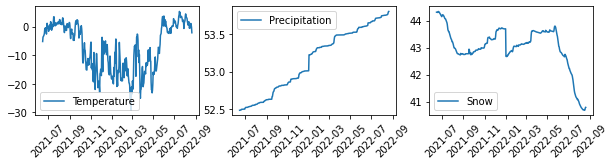

In [248]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(10,2))
axs[0].plot(df_arome_meteo22['TIMESTAMP'], df_arome_meteo22['T_arome'], label='Temperature')
axs[1].plot(df_arome_meteo22['TIMESTAMP'], df_arome_meteo22['P_arome'], label='Precipitation')
axs[2].plot(df_arome_meteo22['TIMESTAMP'], df_arome_meteo22['snow_arome'], label='Snow')
axs[0].legend()
axs[0].tick_params('x',rotation=45)

axs[1].legend()
axs[1].tick_params('x',rotation=45)

axs[2].legend()
axs[2].tick_params('x',rotation=45)


In [246]:
df_arome_meteo22.loc[df_arome_meteo22['TIMESTAMP']=='2021-12-31']

,TIMESTAMP,T_arome,P_arome,snow_arome
199,2021-12-31,-18.140127,53.008797,43.695078


In [251]:
df_arome_meteo22.loc[201]

TIMESTAMP     2022-01-02 00:00:00
T_arome                -18.115717
P_arome                 53.220809
snow_arome                42.6739
Name: 201, dtype: object

In [252]:
dif=df_arome_meteo22['snow_arome'][200]-df_arome_meteo22['snow_arome'][201]
dif

1.0249853505691107

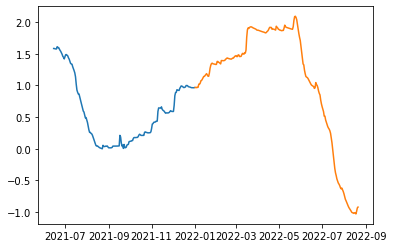

In [264]:
plt.plot(df_arome_meteo22['TIMESTAMP'][:201], df_arome_meteo22['snow_arome'][:201]-(df_arome_meteo22['snow_arome'][:201]).min())
plt.plot(df_arome_meteo22['TIMESTAMP'][201:], df_arome_meteo22['snow_arome'][201:]-(df_arome_meteo22['snow_arome'][:201]).min()+dif)

(0.0, 50.0)

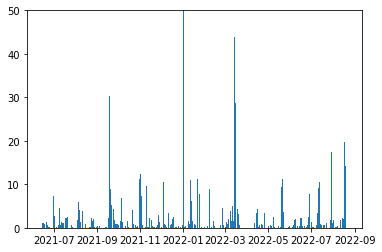

In [159]:
plt.bar(df_arome_meteo22['TIMESTAMP'][:-1], np.diff(df_arome_meteo22['P_arome'])*1000)
plt.ylim([0, 50])

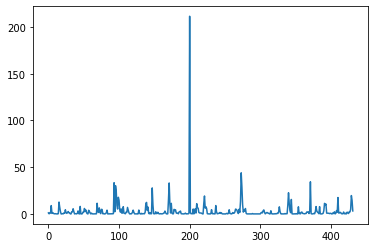

In [160]:
plt.plot((np.diff(df_arome_meteo22['P_arome'])*1000))

In [161]:
data_carra['T2m'][:,0]

array([ -4.3985353,  -5.444739 ,  -3.5584474, ..., -18.01975  ,
       -17.66503  , -17.481543 ], dtype=float32)

In [162]:
data_temp_precip_21 = pd.DataFrame({'TIMESTAMP': data_carra['time'].tolist(), 'T2m': data_carra['T2m'][:,0].tolist(), 'Precip':data_carra['precipitation'][:,0].tolist()})

In [163]:
data_temp_precip_21

,TIMESTAMP,T2m,Precip
0,01-Jan-2021 00:00:00,-4.398535,0.649313
1,01-Jan-2021 03:00:00,-5.444739,0.049878
2,01-Jan-2021 06:00:00,-3.558447,0.082193
3,01-Jan-2021 09:00:00,-5.192084,0.008562
4,01-Jan-2021 12:00:00,-1.937842,0.595787
...,...,...,...
2923,01-Jan-2022 09:00:00,-17.555426,0.078045
2924,01-Jan-2022 12:00:00,-18.333258,0.006721
2925,01-Jan-2022 15:00:00,-18.019751,0.000000
2926,01-Jan-2022 18:00:00,-17.665030,0.000000


In [164]:
data_temp_precip_21['TIMESTAMP']=pd.to_datetime(data_temp_precip_21['TIMESTAMP'])

In [165]:
df_st=data_st.to_dataframe()
df_st.reset_index(inplace=True)

In [166]:
df_st['TIMESTAMP']=pd.to_datetime(df_st['time'])
df_st

,time,station,orog,latitude,longitude,slope,azimuth,dw,snd,ps,hur,ta,ts,ws,TIMESTAMP
0,2021-04-29 12:00:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,136.003326,NaN,95987.960938,0.629486,267.519775,265.760010,0.209983,2021-04-29 12:00:00
1,2021-04-29 12:10:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,134.003326,NaN,95801.304688,0.635091,267.669739,265.760010,0.219983,2021-04-29 12:10:00
2,2021-04-29 12:20:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,114.033333,NaN,95092.179688,0.672837,261.420441,254.339066,2.196700,2021-04-29 12:20:00
3,2021-04-29 12:30:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,308.674988,NaN,95076.023438,0.582451,264.195343,254.799194,0.263233,2021-04-29 12:30:00
4,2021-04-29 12:40:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,268.068329,NaN,95099.960938,0.656077,262.952087,261.209290,5.920550,2021-04-29 12:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49640,2022-04-09 14:40:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,110.995003,NaN,95733.015625,0.915917,264.369141,262.178955,6.837817,2022-04-09 14:40:00
49641,2022-04-09 14:50:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,113.995003,NaN,95730.000000,0.915201,263.870819,261.860535,5.651983,2022-04-09 14:50:00
49642,2022-04-09 15:00:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,117.993332,NaN,95749.968750,0.913103,261.074677,259.963165,3.743183,2022-04-09 15:00:00
49643,2022-04-09 15:10:00,b'sw-001',530.0,78.781021,13.147508,NaN,NaN,114.006668,NaN,95756.992188,0.923682,260.650696,259.420898,3.260800,2022-04-09 15:10:00


In [167]:
df_st.columns

Index(['time', 'station', 'orog', 'latitude', 'longitude', 'slope', 'azimuth',
       'dw', 'snd', 'ps', 'hur', 'ta', 'ts', 'ws', 'TIMESTAMP'],
      dtype='object')

In [168]:
df_snow_depth=df_st[['TIMESTAMP', 'snd', 'ta']]

In [169]:
df_snow_depth.set_index('TIMESTAMP', inplace=True)

In [170]:
data_temp_precip_21.set_index('TIMESTAMP', inplace=True)

In [171]:
mask = (data_temp_precip_21.index >='2021-06-15 00:00:00')
df_temp_precip = data_temp_precip_21.loc[mask]

In [172]:
mask = (df_snow_depth.index >='2021-06-15 00:00:00')
df_snow_depth = df_snow_depth.loc[mask]

In [173]:
df_arome_meteo22_3H=df_arome_meteo22.set_index('TIMESTAMP').resample('3H').mean()

In [174]:
df_arome_meteo22_3H.columns

Index(['T_arome', 'P_arome', 'snow_arome'], dtype='object')

In [175]:
df_arome_meteo22_3H['Ta_int']=df_arome_meteo22_3H['T_arome'].interpolate()
df_arome_meteo22_3H['Pa_int']=df_arome_meteo22_3H['P_arome'].interpolate()
df_arome_meteo22_3H['Snowa_int']=df_arome_meteo22_3H['snow_arome'].interpolate()

In [176]:
df_arome_meteo22_3H=df_arome_meteo22_3H.drop(columns=['T_arome', 'P_arome', 'snow_arome'])

In [177]:
df_arome_meteo22_3H

,Ta_int,Pa_int,Snowa_int
TIMESTAMP,,,
2021-06-15 00:00:00,-5.244239,52.485739,25.500304
2021-06-15 03:00:00,-5.054297,52.485875,25.500440
2021-06-15 06:00:00,-4.864356,52.486010,25.500575
2021-06-15 09:00:00,-4.674414,52.486146,25.500711
2021-06-15 12:00:00,-4.484473,52.486281,25.500846
...,...,...,...
2022-08-20 12:00:00,-1.210992,53.795643,4.893230
2022-08-20 15:00:00,-1.454906,53.796042,4.893592
2022-08-20 18:00:00,-1.698819,53.796442,4.893954


In [178]:
df_snowdepth_3H = df_snow_depth.resample('3H').mean()

In [179]:
df_snowdepth_3H

,snd,ta
TIMESTAMP,,
2021-06-15 00:00:00,NaN,269.252747
2021-06-15 03:00:00,NaN,269.479889
2021-06-15 06:00:00,NaN,269.649841
2021-06-15 09:00:00,NaN,270.330078
2021-06-15 12:00:00,NaN,270.732208
...,...,...
2022-04-09 03:00:00,NaN,257.144135
2022-04-09 06:00:00,NaN,262.755463
2022-04-09 09:00:00,NaN,263.916046


In [180]:
df_snowdepth_3H['snd_int']=df_snowdepth_3H['snd'].interpolate()

In [181]:
df_snowdepth_3H.drop(columns=['snd'], inplace=True)

In [182]:
df_climate1=pd.concat([df_snowdepth_3H, df_temp_precip], axis=1)

In [183]:
df_climate = pd.concat([df_climate1, df_arome_meteo22_3H], axis=1)

In [184]:
df_climate

,ta,snd_int,T2m,Precip,Ta_int,Pa_int,Snowa_int
TIMESTAMP,,,,,,,
2021-06-15 00:00:00,269.252747,NaN,-4.003516,0.141777,-5.244239,52.485739,25.500304
2021-06-15 03:00:00,269.479889,NaN,-3.631201,0.045630,-5.054297,52.485875,25.500440
2021-06-15 06:00:00,269.649841,NaN,-3.916113,0.012501,-4.864356,52.486010,25.500575
2021-06-15 09:00:00,270.330078,NaN,-2.769385,0.001814,-4.674414,52.486146,25.500711
2021-06-15 12:00:00,270.732208,NaN,-2.008399,0.001677,-4.484473,52.486281,25.500846
...,...,...,...,...,...,...,...
2022-08-20 12:00:00,NaN,NaN,NaN,NaN,-1.210992,53.795643,4.893230
2022-08-20 15:00:00,NaN,NaN,NaN,NaN,-1.454906,53.796042,4.893592
2022-08-20 18:00:00,NaN,NaN,NaN,NaN,-1.698819,53.796442,4.893954


In [185]:
df_climate.to_csv(path_export+'raw_data_3H/df_climate_3H.csv')

# Create on dataframe including all the data

In [186]:
df_plough_3H_LPe.set_index('TIMESTAMP', inplace=True)

In [187]:
df_seismo

,P3-10,P30-45,R,S
TIMESTAMP,,,,
2021-06-15 00:00:00,-181.124786,-186.341062,NaN,NaN
2021-06-15 03:00:00,-181.002675,-186.356163,NaN,NaN
2021-06-15 06:00:00,-181.148872,-186.345079,NaN,NaN
2021-06-15 09:00:00,-181.145803,-186.331719,NaN,NaN
2021-06-15 12:00:00,-181.114303,-186.301181,NaN,NaN
...,...,...,...,...
2022-08-18 03:00:00,NaN,NaN,NaN,NaN
2022-08-18 06:00:00,NaN,NaN,NaN,NaN
2022-08-18 09:00:00,NaN,NaN,NaN,NaN


In [188]:
df=pd.concat([df_plough_3H_LPe, df_seismo], axis=1)

In [189]:
data_runoff2122_3H

,Runoff
TIMESTAMP,
2021-06-15 00:00:00,0.000000
2021-06-15 03:00:00,0.000000
2021-06-15 06:00:00,0.000000
2021-06-15 09:00:00,0.000000
2021-06-15 12:00:00,0.000000
...,...
2022-08-17 15:00:00,1.743442
2022-08-17 18:00:00,3.649433
2022-08-17 21:00:00,5.262780


In [190]:
df2 = pd.concat([df, data_runoff2122_3H], axis=1)

In [191]:
df_velocity_int

,Velocity
TIMESTAMP,
2021-09-06 00:00:00,NaN
2021-09-06 03:00:00,NaN
2021-09-06 06:00:00,NaN
2021-09-06 09:00:00,NaN
2021-09-06 12:00:00,NaN
...,...
2022-01-03 12:00:00,32.380376
2022-01-03 15:00:00,32.380376
2022-01-03 18:00:00,32.380376


In [192]:
df3 = pd.concat([df2, df_all_velocity], axis=1)

In [193]:
df_all_data_3H = pd.concat([df3, df_climate], axis=1)

## Remove data for R and S if the Runoff is < 0.5

In [194]:
df_all_data_3H.loc[df_all_data_3H.Runoff <= 0.5, 'R'] = np.nan

In [195]:
df_all_data_3H.loc[df_all_data_3H.Runoff <= 0.5, 'S'] = np.nan

## Add Time column in relative time

In [196]:
df_all_data_3H['Time']= np.arange(0, df_all_data_3H.index.shape[0]*(3/24), 3/24)


In [197]:
cols = list(df_all_data_3H.columns)
cols = [cols[-1]] + cols[:-1]
df_all_data_3H = df_all_data_3H[cols]

In [198]:
df_all_data_3H.to_csv(path_export+'raw_data_3H/df_all_data_3H.csv')

# Visualisation of the data

In [199]:
df_all_data_3H

,Time,L,Pe,P3-10,P30-45,R,S,Runoff,Velocity,KNG6,KNG7,KNG5,ta,snd_int,T2m,Precip,Ta_int,Pa_int,Snowa_int
TIMESTAMP,,,,,,,,,,,,,,,,,,,
2021-06-15 00:00:00,0.000,74.485646,2.798299,-181.124786,-186.341062,NaN,NaN,0.0,8.694892,36.342375,30.133125,27.850313,269.252747,NaN,-4.003516,0.141777,-5.244239,52.485739,25.500304
2021-06-15 03:00:00,0.125,74.640594,2.798578,-181.002675,-186.356163,NaN,NaN,0.0,10.106296,31.046250,27.759000,26.663250,269.479889,NaN,-3.631201,0.045630,-5.054297,52.485875,25.500440
2021-06-15 06:00:00,0.250,74.651018,2.798510,-181.148872,-186.345079,NaN,NaN,0.0,11.517700,32.933375,30.620125,27.089375,269.649841,NaN,-3.916113,0.012501,-4.864356,52.486010,25.500575
2021-06-15 09:00:00,0.375,74.841066,2.799789,-181.145803,-186.331719,NaN,NaN,0.0,12.929104,34.333500,33.663875,27.150250,270.330078,NaN,-2.769385,0.001814,-4.674414,52.486146,25.500711
2021-06-15 12:00:00,0.500,75.202417,2.802315,-181.114303,-186.301181,NaN,NaN,0.0,14.340509,38.899125,37.559875,28.306875,270.732208,NaN,-2.008399,0.001677,-4.484473,52.486281,25.500846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-20 12:00:00,431.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.210992,53.795643,4.893230
2022-08-20 15:00:00,431.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.454906,53.796042,4.893592
2022-08-20 18:00:00,431.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.698819,53.796442,4.893954


In [200]:
df_all_data_3H.reset_index(inplace=True)

In [201]:
df_all_data_3H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TIMESTAMP  3458 non-null   datetime64[ns]
 1   Time       3458 non-null   float64       
 2   L          2830 non-null   float64       
 3   Pe         2846 non-null   float64       
 4   P3-10      2702 non-null   float64       
 5   P30-45     2702 non-null   float64       
 6   R          1100 non-null   float64       
 7   S          1100 non-null   float64       
 8   Runoff     3434 non-null   float64       
 9   Velocity   1474 non-null   float64       
 10  KNG6       946 non-null    float64       
 11  KNG7       1772 non-null   float64       
 12  KNG5       1429 non-null   float64       
 13  ta         2390 non-null   float32       
 14  snd_int    2321 non-null   float32       
 15  T2m        1608 non-null   float64       
 16  Precip     1608 non-null   float64       


In [202]:
df_all_data_3H.KNG5-df_all_data_3H.KNG6

0       -8.492063
1       -4.383000
2       -5.844000
3       -7.183250
4      -10.592250
          ...    
3453          NaN
3454          NaN
3455          NaN
3456          NaN
3457          NaN
Length: 3458, dtype: float64

In [203]:
df_all_data_3H.columns

Index(['TIMESTAMP', 'Time', 'L', 'Pe', 'P3-10', 'P30-45', 'R', 'S', 'Runoff',
       'Velocity', 'KNG6', 'KNG7', 'KNG5', 'ta', 'snd_int', 'T2m', 'Precip',
       'Ta_int', 'Pa_int', 'Snowa_int'],
      dtype='object')

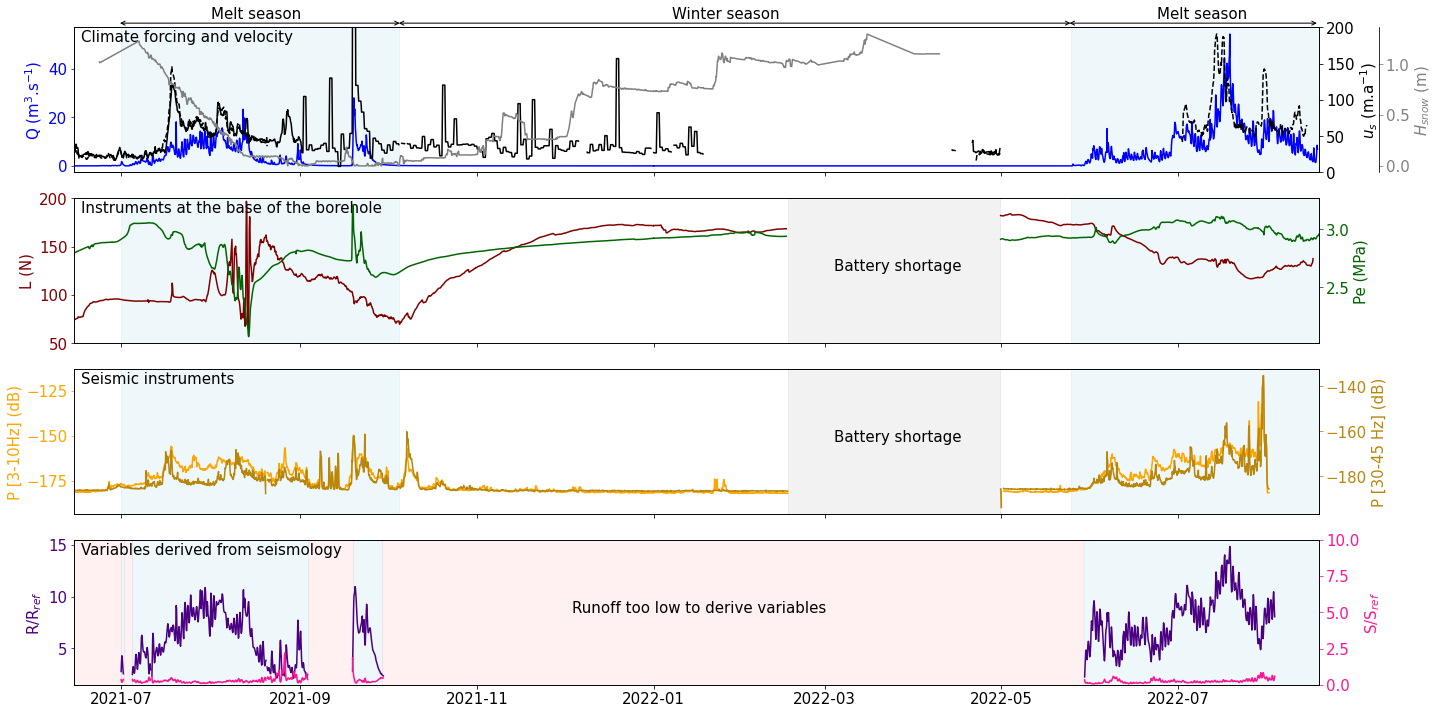

In [204]:
fig, axs = plt.subplots(4,1, figsize = (20,10), sharex=True)

axs[0].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Runoff'], 'b')
axs[0].set_ylabel('Q (m$^3$.s$^{-1}$)', color='b', fontsize=15)
axs[0].tick_params(axis='y', color='b', labelcolor='b', labelsize=15)
axs[0].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][896], alpha=0.2, color='lightblue')
axs[0].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[0].text(0.11, 1.06, 'Melt season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].text(0.87, 1.06, 'Melt season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].text(0.48, 1.06, 'Winter season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].annotate('', xy=(0.035, 1.03), va='center',
                ha='center', xytext=(0.263, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))
axs[0].annotate('', xy=(0.259, 1.03), va='center',
                ha='center', xytext=(0.802, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))

axs[0].annotate('', xy=(0.798, 1.03), va='center',
                ha='center', xytext=(1, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))

axs[0].text(0.005, 0.9, 'Climate forcing and velocity', 
            color='k', 
            fontsize=15, 
            transform=axs[0].transAxes)
axs[0].margins(x=0)
# axs[0].grid()

ax1=axs[0].twinx()
ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG7'], 'k')
ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG6'], 'k--')
# ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG5'], 'k+')

ax1.set_ylabel('$u_s$ (m.a$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim([0, 200])

ax2=axs[0].twinx()
ax2.spines['right'].set_position(("axes", 1.048))
ax2.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['snd_int'], 'grey')
ax2.set_ylabel('$H_{snow}$ (m)', color='grey', fontsize=15)
ax2.tick_params(axis='y', color='grey', labelcolor='grey', labelsize=15)




#------------------------------------------------------------------------

axs[1].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['L'], 'maroon')
axs[1].set_ylabel('L (N)', color='maroon', fontsize=15)
axs[1].set_ylim([50, 200])
axs[1].tick_params(axis='y', color='maroon', labelcolor='maroon', labelsize=15)
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][896], alpha=0.2, color='lightblue')
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[1].margins(x=0)
axs[1].text(0.005, 0.9, 'Instruments at the base of the borehole', 
            color='k', 
            fontsize=15, 
            transform=axs[1].transAxes)
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][1971], df_all_data_3H['TIMESTAMP'][2558], alpha=0.1, color='grey')
axs[1].text(0.61, 0.5, 'Battery shortage', 
            color='k', 
            fontsize=15, 
            transform=axs[1].transAxes)
# axs[1].grid()


ax3=axs[1].twinx()
ax3.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Pe'], 'darkgreen')
ax3.set_ylabel('Pe (MPa)', color='darkgreen', fontsize=15)
ax3.tick_params(axis='y', color='darkgreen', labelcolor='darkgreen', labelsize=15)

#------------------------------------------------------------------------

axs[2].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['P3-10'], 'orange')
axs[2].set_ylabel('P [3-10Hz] (dB)', color='orange', fontsize=15)
axs[2].tick_params(axis='y', color='orange', labelcolor='orange', labelsize=15)
axs[2].tick_params(axis='x', labelsize=15)
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][896], alpha=0.2, color='lightblue')
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[2].text(0.005, 0.9, 'Seismic instruments', 
            color='k', 
            fontsize=15, 
            transform=axs[2].transAxes)
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][1971], df_all_data_3H['TIMESTAMP'][2558], alpha=0.1, color='grey')
axs[2].text(0.61, 0.5, 'Battery shortage', 
            color='k', 
            fontsize=15, 
            transform=axs[2].transAxes)
# axs[2].grid()

ax4=axs[2].twinx()
ax4.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['P30-45'], 'darkgoldenrod')
ax4.set_ylabel('P [30-45 Hz] (dB)', color='darkgoldenrod', fontsize=15)
ax4.tick_params(axis='y', color='darkgoldenrod', labelcolor='darkgoldenrod', labelsize=15)
ax4.tick_params(axis='x', labelsize=15)

#------------------------------------------------------------------------

axs[3].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['R'], 'indigo')
axs[3].set_ylabel('R/R$_{ref}$', color='indigo', fontsize=15)
axs[3].tick_params(axis='y', color='indigo', labelcolor='indigo', labelsize=15)
axs[3].tick_params(axis='x', labelsize=15)

axs[3].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][137], alpha=0.2, color='lightblue')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][160], df_all_data_3H['TIMESTAMP'][644], alpha=0.2, color='lightblue')

axs[3].axvspan(df_all_data_3H['TIMESTAMP'][770], df_all_data_3H['TIMESTAMP'][849], alpha=0.2, color='lightblue')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][2788], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[3].margins(x=0)
axs[3].text(0.005, 0.9, 'Variables derived from seismology', 
            color='k', 
            fontsize=15, 
            transform=axs[3].transAxes)
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][850], df_all_data_3H['TIMESTAMP'][2787], alpha=0.2, color='lightpink')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][645], df_all_data_3H['TIMESTAMP'][770], alpha=0.2, color='lightpink')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][0], df_all_data_3H['TIMESTAMP'][128], alpha=0.2, color='lightpink')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][138], df_all_data_3H['TIMESTAMP'][160], alpha=0.2, color='lightpink')
axs[3].text(0.4, 0.5, 'Runoff too low to derive variables', 
            color='k', 
            fontsize=15, 
            transform=axs[3].transAxes)
# axs[3].grid()

ax5 = axs[3].twinx()
ax5.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['S'], 'deeppink')
ax5.set_ylabel('S/S$_{ref}$', color='deeppink', fontsize=15)
ax5.tick_params(axis='y', color='deeppink', labelcolor='deeppink', labelsize=15)
ax5.tick_params(axis='x', labelsize=15)
ax5.set_ylim([0, 10])
ax5.margins(x=0)


plt.tight_layout()
plt.savefig('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Figure/Figure_clean_paper/all_raw_data_2122.pdf', bbox_inches='tight')

In [205]:
df_all_data_3H.loc[3438]

TIMESTAMP    2022-08-18 15:00:00
Time                      429.75
L                            NaN
Pe                      2.955964
P3-10                        NaN
P30-45                       NaN
R                            NaN
S                            NaN
Runoff                       NaN
Velocity                     NaN
KNG6                         NaN
KNG7                         NaN
KNG5                         NaN
ta                           NaN
snd_int                      NaN
T2m                          NaN
Precip                       NaN
Ta_int                  0.794232
Pa_int                 53.772374
Snowa_int               4.873889
Name: 3438, dtype: object

In [206]:
df_all_data_3H

,TIMESTAMP,Time,L,Pe,P3-10,P30-45,R,S,Runoff,Velocity,KNG6,KNG7,KNG5,ta,snd_int,T2m,Precip,Ta_int,Pa_int,Snowa_int
0,2021-06-15 00:00:00,0.000,74.485646,2.798299,-181.124786,-186.341062,NaN,NaN,0.0,8.694892,36.342375,30.133125,27.850313,269.252747,NaN,-4.003516,0.141777,-5.244239,52.485739,25.500304
1,2021-06-15 03:00:00,0.125,74.640594,2.798578,-181.002675,-186.356163,NaN,NaN,0.0,10.106296,31.046250,27.759000,26.663250,269.479889,NaN,-3.631201,0.045630,-5.054297,52.485875,25.500440
2,2021-06-15 06:00:00,0.250,74.651018,2.798510,-181.148872,-186.345079,NaN,NaN,0.0,11.517700,32.933375,30.620125,27.089375,269.649841,NaN,-3.916113,0.012501,-4.864356,52.486010,25.500575
3,2021-06-15 09:00:00,0.375,74.841066,2.799789,-181.145803,-186.331719,NaN,NaN,0.0,12.929104,34.333500,33.663875,27.150250,270.330078,NaN,-2.769385,0.001814,-4.674414,52.486146,25.500711
4,2021-06-15 12:00:00,0.500,75.202417,2.802315,-181.114303,-186.301181,NaN,NaN,0.0,14.340509,38.899125,37.559875,28.306875,270.732208,NaN,-2.008399,0.001677,-4.484473,52.486281,25.500846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3453,2022-08-20 12:00:00,431.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.210992,53.795643,4.893230
3454,2022-08-20 15:00:00,431.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.454906,53.796042,4.893592
3455,2022-08-20 18:00:00,431.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.698819,53.796442,4.893954
3456,2022-08-20 21:00:00,432.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.942733,53.796841,4.894315


In [207]:
df_arome_meteo22_3H

,Ta_int,Pa_int,Snowa_int
TIMESTAMP,,,
2021-06-15 00:00:00,-5.244239,52.485739,25.500304
2021-06-15 03:00:00,-5.054297,52.485875,25.500440
2021-06-15 06:00:00,-4.864356,52.486010,25.500575
2021-06-15 09:00:00,-4.674414,52.486146,25.500711
2021-06-15 12:00:00,-4.484473,52.486281,25.500846
...,...,...,...
2022-08-20 12:00:00,-1.210992,53.795643,4.893230
2022-08-20 15:00:00,-1.454906,53.796042,4.893592
2022-08-20 18:00:00,-1.698819,53.796442,4.893954


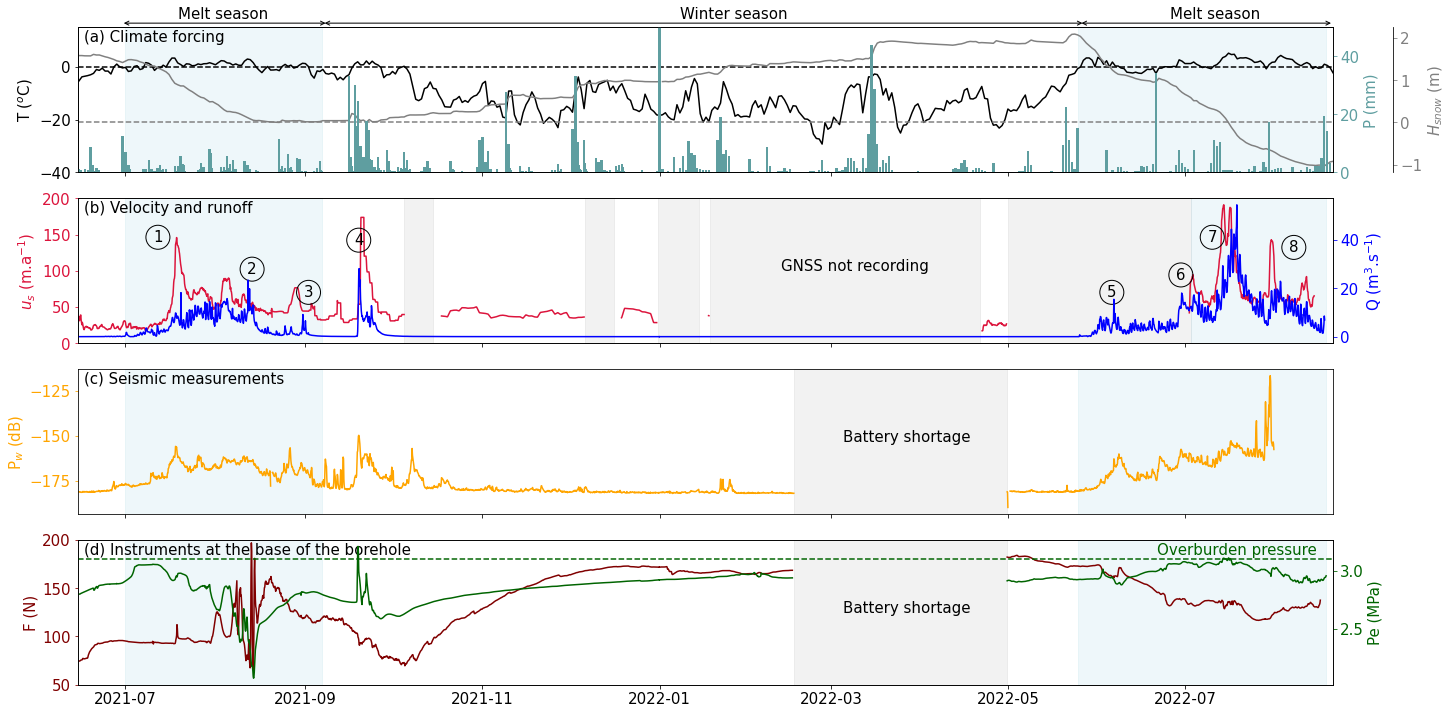

In [284]:
fig, axs = plt.subplots(4,1, figsize = (20,10), sharex=True)

## Climate forcing
axs[0].annotate('', xy=(0.035, 1.03), va='center',
                ha='center', xytext=(0.199, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))
axs[0].annotate('', xy=(0.195, 1.03), va='center',
                ha='center', xytext=(0.802, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))

axs[0].annotate('', xy=(0.798, 1.03), va='center',
                ha='center', xytext=(1, 1.03), xycoords='axes fraction', horizontalalignment="center", 
                arrowprops=dict(arrowstyle="<->", color='k'))

axs[0].text(0.005, 0.9, '(a) Climate forcing', 
            color='k', 
            fontsize=15, 
            transform=axs[0].transAxes)

# axs[0].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['T'], 'k--')
axs[0].plot(df_arome_meteo22['TIMESTAMP'], df_arome_meteo22['T_arome'], 'k')
axs[0].axhline(y=0, color='k', linestyle='--')
# axs[0].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['ta']-273, 'k')
# axs[0].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['ta']-273, 'k')
axs[0].set_ylabel('T ($^o$C)', color='k', fontsize=15)
axs[0].set_ylim([-40, 15])
axs[0].tick_params(axis='y', color='k', labelcolor='k', labelsize=15)
axs[0].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][670], alpha=0.2, color='lightblue')
axs[0].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[0].text(0.08, 1.06, 'Melt season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].text(0.87, 1.06, 'Melt season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].text(0.48, 1.06, 'Winter season', color='k', fontsize=15, transform=axs[0].transAxes)
axs[0].margins(x=0)


# axs[0].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Ta_int'], 'k')

ax1=axs[0].twinx()
ax1.spines['right'].set_position(("axes", 1.048))
# ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['snd_int'], 'grey')
ax1.plot(df_arome_meteo22['TIMESTAMP'][:201], df_arome_meteo22['snow_arome'][:201]-(df_arome_meteo22['snow_arome'][:201]).min(), 'grey')
ax1.plot(df_arome_meteo22['TIMESTAMP'][201:], df_arome_meteo22['snow_arome'][201:]-(df_arome_meteo22['snow_arome'][:201]).min()+dif, 'grey')
ax1.axhline(y=0, color='grey', linestyle='--')
ax1.set_ylabel('$H_{snow}$ (m)', color='grey', fontsize=15)
ax1.tick_params(axis='y', color='grey', labelcolor='grey', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
# ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Snowa_int'], 'grey')

ax2=axs[0].twinx()
ax2.bar(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Precip'], color='cadetblue')
ax2.bar(df_arome_meteo22['TIMESTAMP'][:-1], np.diff(df_arome_meteo22['P_arome'])*1000, color='cadetblue')
ax2.set_ylim([0, 50])
ax2.set_ylabel('P (mm)', color='cadetblue', fontsize=15)
ax2.tick_params(axis='y', color='cadetblue', labelcolor='cadetblue', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
# ax2.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Pa_int'], color='cadetblue')

ax1.margins(x=0)

##Velocity
KNG7_median = df_all_data_3H['KNG7'].rolling(18).median()
KNG7_median_2 = df_all_data_3H['KNG7'].rolling(80).mean()


# KNG7 = KNG7_median.interpolate(0)

axs[1].plot(df_all_data_3H['TIMESTAMP'][530:900], KNG7_median[530:900], 'crimson', linestyle='-')
axs[1].plot(df_all_data_3H['TIMESTAMP'][901:], KNG7_median_2[901:], 'crimson', linestyle='-')

axs[1].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG6'], 'crimson', linestyle='-')
# ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG5'], 'k+')
axs[1].tick_params(axis='y', color='crimson', labelcolor='crimson', labelsize=15)
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][897], df_all_data_3H['TIMESTAMP'][975], alpha=0.1, color='grey')
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][1395], df_all_data_3H['TIMESTAMP'][1475], alpha=0.1, color='grey')
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][1595], df_all_data_3H['TIMESTAMP'][1710], alpha=0.1, color='grey')

axs[1].axvspan(df_all_data_3H['TIMESTAMP'][1740], df_all_data_3H['TIMESTAMP'][2485], alpha=0.1, color='grey')
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][2560], df_all_data_3H['TIMESTAMP'][3065], alpha=0.1, color='grey')

axs[1].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][670], alpha=0.2, color='lightblue')
axs[1].axvspan(df_all_data_3H['TIMESTAMP'][3066], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')

axs[1].set_ylabel('$u_s$ (m.a$^{-1}$)', color='crimson', fontsize=15)
axs[1].tick_params(axis='y', labelsize=15)
axs[1].set_ylim([0, 200])
axs[1].text(0.005, 0.9, '(b) Velocity and runoff', 
            color='k', 
            fontsize=15, 
            transform=axs[1].transAxes)
axs[1].text(0.56, 0.5, 'GNSS not recording', 
            color='k', 
            fontsize=15, 
            transform=axs[1].transAxes)

axs[1].text(0.06, 0.7, '1', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
# axs[1].text(0.10, 0.7, '2', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.135, 0.48, '2', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.18, 0.32, '3', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.22, 0.68, '4', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
# axs[1].text(0.5, 0.7, '6', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.82, 0.32, '5', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.875, 0.44, '6', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.9, 0.7, '7', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1].text(0.965, 0.63, '8', color='k', fontsize=15, transform=axs[1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))


axs[1].margins(x=0)

##Runoff
ax1=axs[1].twinx()
# ax1text(0.005, 0.9, 'Modelled runoff', 
#             color='k', 
#             fontsize=15, 
#             transform=axs[1].transAxes)
ax1.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Runoff'], 'b')
ax1.set_ylabel('Q (m$^3$.s$^{-1}$)', color='b', fontsize=15)
ax1.tick_params(axis='y', color='b', labelcolor='b', labelsize=15)
ax1.margins(x=0)



##Sismo
axs[2].plot(df_all_data_3H['TIMESTAMP'][0:3295], df_all_data_3H['P3-10'][0:3295], 'orange')
axs[2].set_ylabel('P$_w$ (dB)', color='orange', fontsize=15)
axs[2].tick_params(axis='y', color='orange', labelcolor='orange', labelsize=15)
axs[2].tick_params(axis='x', labelsize=15)
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][670], alpha=0.2, color='lightblue')
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[2].text(0.005, 0.9, '(c) Seismic measurements', 
            color='k', 
            fontsize=15, 
            transform=axs[2].transAxes)
axs[2].axvspan(df_all_data_3H['TIMESTAMP'][1971], df_all_data_3H['TIMESTAMP'][2558], alpha=0.1, color='grey')
axs[2].text(0.61, 0.5, 'Battery shortage', 
            color='k', 
            fontsize=15, 
            transform=axs[2].transAxes)
axs[2].margins(x=0)

# ax4=axs[2].twinx()
# ax4.plot(df_all_data_3H['TIMESTAMP'][0:3295], df_all_data_3H['P30-45'][0:3295], 'darkgoldenrod')
# ax4.set_ylabel('P [30-45 Hz] (dB)', color='darkgoldenrod', fontsize=15)
# ax4.tick_params(axis='y', color='darkgoldenrod', labelcolor='darkgoldenrod', labelsize=15)
# ax4.tick_params(axis='x', labelsize=15)


##Borehole measurement

axs[3].plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['L'], 'maroon')
axs[3].set_ylabel('F (N)', color='maroon', fontsize=15)
axs[3].set_ylim([50, 200])
axs[3].tick_params(axis='y', color='maroon', labelcolor='maroon', labelsize=15)
axs[3].tick_params(axis='x', labelsize=15)
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][670], alpha=0.2, color='lightblue')
# axs[3].axvspan(df_all_data_3H['TIMESTAMP'][128], df_all_data_3H['TIMESTAMP'][896], alpha=0.2, color='lightblue')
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][2753], df_all_data_3H['TIMESTAMP'][3438], alpha=0.2, color='lightblue')
axs[3].margins(x=0)
axs[3].text(0.005, 0.9, '(d) Instruments at the base of the borehole', 
            color='k', 
            fontsize=15, 
            transform=axs[3].transAxes)
axs[3].axvspan(df_all_data_3H['TIMESTAMP'][1971], df_all_data_3H['TIMESTAMP'][2558], alpha=0.1, color='grey')
axs[3].text(0.61, 0.5, 'Battery shortage', 
            color='k', 
            fontsize=15, 
            transform=axs[3].transAxes)
axs[3].text(0.86, 0.9, 'Overburden pressure', 
            color='darkgreen', 
            fontsize=15, 
            transform=axs[3].transAxes)
axs[3].margins(x=0)


ax3=axs[3].twinx()
ax3.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['Pe'], 'darkgreen')
ax3.axhline(y = 3.1, xmin=0, xmax=1971, color = 'darkgreen', linestyle = '--')
ax3.set_ylabel('Pe (MPa)', color='darkgreen', fontsize=15)
ax3.tick_params(axis='y', color='darkgreen', labelcolor='darkgreen', labelsize=15)
ax3.tick_params(axis='x', labelsize=15)
ax3.margins(x=0)


plt.tight_layout()
plt.savefig('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Figure/Figure_clean_paper/all_raw_data_2122_forcing.pdf', bbox_inches='tight')

In [209]:
df_all_data_3H

,TIMESTAMP,Time,L,Pe,P3-10,P30-45,R,S,Runoff,Velocity,KNG6,KNG7,KNG5,ta,snd_int,T2m,Precip,Ta_int,Pa_int,Snowa_int
0,2021-06-15 00:00:00,0.000,74.485646,2.798299,-181.124786,-186.341062,NaN,NaN,0.0,8.694892,36.342375,30.133125,27.850313,269.252747,NaN,-4.003516,0.141777,-5.244239,52.485739,25.500304
1,2021-06-15 03:00:00,0.125,74.640594,2.798578,-181.002675,-186.356163,NaN,NaN,0.0,10.106296,31.046250,27.759000,26.663250,269.479889,NaN,-3.631201,0.045630,-5.054297,52.485875,25.500440
2,2021-06-15 06:00:00,0.250,74.651018,2.798510,-181.148872,-186.345079,NaN,NaN,0.0,11.517700,32.933375,30.620125,27.089375,269.649841,NaN,-3.916113,0.012501,-4.864356,52.486010,25.500575
3,2021-06-15 09:00:00,0.375,74.841066,2.799789,-181.145803,-186.331719,NaN,NaN,0.0,12.929104,34.333500,33.663875,27.150250,270.330078,NaN,-2.769385,0.001814,-4.674414,52.486146,25.500711
4,2021-06-15 12:00:00,0.500,75.202417,2.802315,-181.114303,-186.301181,NaN,NaN,0.0,14.340509,38.899125,37.559875,28.306875,270.732208,NaN,-2.008399,0.001677,-4.484473,52.486281,25.500846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3453,2022-08-20 12:00:00,431.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.210992,53.795643,4.893230
3454,2022-08-20 15:00:00,431.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.454906,53.796042,4.893592
3455,2022-08-20 18:00:00,431.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.698819,53.796442,4.893954
3456,2022-08-20 21:00:00,432.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.942733,53.796841,4.894315


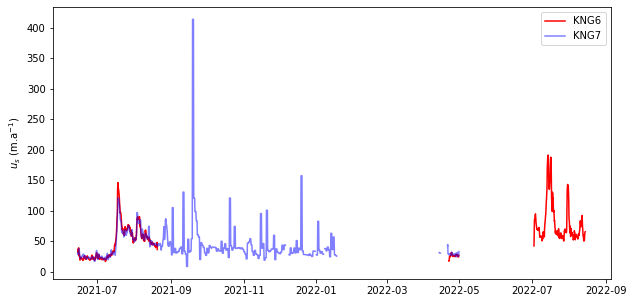

In [210]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG6'], 'red', label='KNG6')
axs.plot(df_all_data_3H['TIMESTAMP'], df_all_data_3H['KNG7'], 'blue', label='KNG7', alpha=0.5)
axs.legend()
axs.set_ylabel('$u_s$ (m.a$^{-1}$)')
plt.savefig('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Figure/Figure_clean_paper/velocity_data_sup.pdf', bbox_inches='tight')